####Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

#####Load MNIST Dataset


In [2]:
# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 157656340.63it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 97454299.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28718451.76it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 25333149.96it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#####Visualize MNIST Dataset:

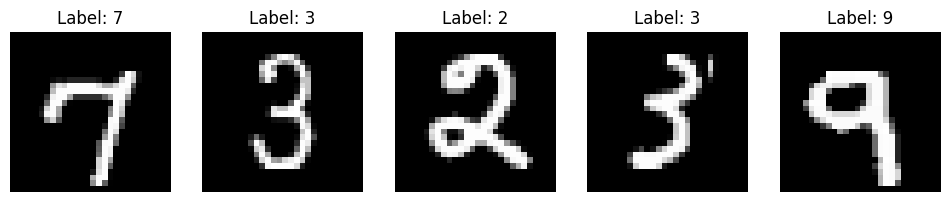

In [3]:
def show_samples(images, labels, n_samples=5):
    fig, axes = plt.subplots(1, n_samples, figsize=(12, 3))
    for i in range(n_samples):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {labels[i]}')
        axes[i].axis('off')
    plt.show()

# Get a batch of training data for visualization
sample_images, sample_labels = next(iter(train_loader))
show_samples(sample_images, sample_labels)

####Design Neural Network Model

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Initialize the model
input_size = 28 * 28  # MNIST image size
hidden_size = 128
num_classes = 10
model = NeuralNet(input_size, hidden_size, num_classes)

####Set Hyperparameters and Loss Function

In [5]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

####Training Loop

In [6]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training finished.')

Epoch [1/10], Loss: 0.1872
Epoch [2/10], Loss: 0.0720
Epoch [3/10], Loss: 0.1015
Epoch [4/10], Loss: 0.2506
Epoch [5/10], Loss: 0.0880
Epoch [6/10], Loss: 0.0852
Epoch [7/10], Loss: 0.1400
Epoch [8/10], Loss: 0.1829
Epoch [9/10], Loss: 0.1260
Epoch [10/10], Loss: 0.0394
Training finished.


####Evaluate the Model

In [10]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []

    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    accuracy = 100 * (accuracy_score(true_labels, predicted_labels))
    f1 = 100 * (f1_score(true_labels, predicted_labels, average='weighted'))
    precision = 100 * (precision_score(true_labels, predicted_labels, average='weighted'))
    recall = 100 * (recall_score(true_labels, predicted_labels, average='weighted'))

    print(f'Accuracy: {accuracy:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')

    cm = confusion_matrix(true_labels, predicted_labels)
    print('Confusion Matrix:')
    print(cm)

Accuracy: 97.18
F1 Score: 97.18
Precision: 97.20
Recall: 97.18
Confusion Matrix:
[[ 957    0    6    0    2    3    5    5    2    0]
 [   0 1126    4    2    0    0    1    0    2    0]
 [   3    2 1016    0    2    0    1    4    4    0]
 [   0    0    9  986    0   10    0    2    2    1]
 [   0    0    7    1  954    0    4    2    1   13]
 [   3    0    1    5    2  870    5    1    3    2]
 [   3    4    3    1    3    4  935    1    4    0]
 [   1   12   18    8    1    0    1  982    2    3]
 [   3    0   12   17    4    3    4    3  928    0]
 [   2    3    1   14    9    3    1   10    2  964]]


####Explaining the result

High accuracy (close to 1.0) indicates that the model is generally good at classifying digits.

A high F1 score, precision, and recall suggest that the model performs well in terms of both positive and negative predictions. In this context, it means the model is effective at classifying both digits and non-digits.

The confusion matrix provides insights into specific areas of model performance. You can identify which digits are challenging for the model and whether it has a bias towards certain classes.